<a href="https://colab.research.google.com/github/josipbencic/kaggle/blob/master/predict_future_sales_josip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive

ROOT = "/content/drive"     # default location for the drive
PROJECT_PATH = "/content/drive/My Drive/kaggle_tmp"

drive.mount(ROOT)           # we mount the google drive at /content/drive

GIT_TOKEN = "13b32b3481c45a9a7bdd7f223644aa47b1156c42"
GIT_USERNAME = "josipbencic"
GIT_REPOSITORY = "kaggle"

GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"

!git clone "{GIT_PATH}" ./temp      # clone github repository to temp folder
!mv ./temp/* "{PROJECT_PATH}"       # move all files/folders in temp folder to folder defined in project path
!rm -rf ./temp                      # remove all the files/folders in temp folder
#!rsync -aP --exclude=data/ "{PROJECT_PATH}"/*  ./   # use remote sync to copy from google drive to local runtime google colab
                                                     # but exclude data folder                                          
!rsync -aP "{PROJECT_PATH}"/*  ./

!pip install category_encoders

## Inspect collab machine
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
#import GPUtil as GPU
#GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
#gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 #print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
%%time

from typing import List, Set, Dict, Tuple, Optional
import argparse
import sys
import os
import csv
import time
import math
from datetime import date
from math import floor

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

file_prefix = './data/'
SPAN = 3

def get_cv_dataset(sales_original, month):
  cv = sales_original[sales_original.date_block_num == month].copy()
  cvdf = cv.groupby(['shop_id', 'item_id']).agg(
      sold = pd.NamedAgg(column = 'item_cnt_day', aggfunc = 'sum'),
      price = pd.NamedAgg(column = 'item_price', aggfunc = 'first')
  )
  cvdf.reset_index(drop = False, inplace = True)
  cvdf.set_index('item_id', drop = True, inplace = True)
  cvdf = cvdf.join(items, on = 'item_id')
  cvdf.reset_index(inplace = True, drop = False)
  

  for it in range(1, SPAN + 1):
    prev = sales_original[sales_original.date_block_num == month - it]
    pdf = prev.groupby(['shop_id', 'item_id']).agg(
        sold = pd.NamedAgg(column = 'item_cnt_day', aggfunc = 'sum'),
        price = pd.NamedAgg(column = 'item_price', aggfunc = 'first')
    )
    cvdf = cvdf.join(pdf, on = ['shop_id', 'item_id'], rsuffix = '_' + str(it))
    cvdf['sold_' + str(it)] = cvdf['sold_' + str(it)].fillna(0)
    cvdf['price_' + str(it)] = cvdf['price_' + str(it)].fillna(method = 'backfill')
    cvdf['price_' + str(it)] = cvdf['price_' + str(it)].fillna(method = 'ffill')

  return cvdf

### Thoughts:
## - aggregate items per category
##    - there are only ~80 categories, while 20k items
##    - this will reduce the dimensionality in the final version and make
##        the model less interpretable, albeit less accurate
##    - what to do with the prices!!??
##       - Around 15.5k of items have changed their price over time, ~70%
##    - can do 2 versions and then cross validate:
##        - with averaged and with summed volumes per item
##    - the alternative is to use this column as a latent variable
## - battle non-stationarity by building a model only with items that are
##    still being sold
## - add item price and volume history in the past months as columns
## - add a column that asks if the item existed a year ago
## - add a column that says how many items of such were sold last year
##    in that month
## - add last month's sales
## - add a few last months' price
## - try to backtrade the model to optimize for the parameters

### Load the datasets from disk
itemCategories=pd.read_csv(file_prefix + 'item_categories.csv')
shops=pd.read_csv(file_prefix + 'shops.csv')
test=pd.read_csv(file_prefix + 'test.csv')
sales_original = pd.read_csv(file_prefix + 'sales_train.csv')

items = pd.read_csv(file_prefix + 'items.csv')
items = items.drop('item_name', axis = 1)
items.set_index('item_id', inplace = True)

CPU times: user 1.22 s, sys: 219 ms, total: 1.44 s
Wall time: 1.46 s


In [42]:
%%time
sales = sales_original.copy()

## Separate the cross-validation set
## TODO: implement "rolling" cross-validation
## Filter here so that we are not using the future data
sales = sales[sales.date_block_num < 32]

## Aggregate prices and sales over months
df = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    sold = pd.NamedAgg(column = 'item_cnt_day', aggfunc = 'sum'),
    price = pd.NamedAgg(column = 'item_price', aggfunc = 'first')
)
df.reset_index(drop = False, inplace = True)

## Append item_id category variable from the other dataset
df.set_index('item_id', drop = True, inplace = True)
df = df.join(items, on = 'item_id')
df.reset_index(inplace = True, drop = False)


### append historic data for up to SPAN months before
aggs = df.copy()
aggs.drop(inplace = True, columns = ['item_category_id'])
aggs.rename(columns = {'date_block_num': 'date_block_before'}, inplace = True)
aggs.set_index(
    ['item_id', 'shop_id', 'date_block_before'], inplace = True, drop = True)
for it in range(1, SPAN + 1):
  df['date_block_before'] = df.date_block_num - it
  ## Here is where we filter for the first month/s to always have all features
  ## (some features are computed back in time, eg. last month's price)
  df = df[df.date_block_before >= 0]
  df = df.join(
      aggs,
      on = ['item_id', 'shop_id', 'date_block_before'],
      rsuffix = ('_' + str(it))
  )
  df.drop('date_block_before', axis = 1, inplace = True)

  #### Some combinations of shop-item have 0 sales in some months
  ## those items that haven't had any sales in the given slots are assigned 0
  ## instead of NaN
  df['sold_' + str(it)] = df['sold_' + str(it)].fillna(0)
  ## If the price wasn't present at the time:
  ##   - first, fill backwards in time the last price (works with multiple prices)
  ##   - then fill front
  df['price_' + str(it)] = df['price_' + str(it)].fillna(method = 'backfill')
  df['price_' + str(it)] = df['price_' + str(it)].fillna(method = 'ffill')


## Can't use any variable that represents time, because it will
## memorize the dataset (eg. if it knows the prices are a bit higher in
## 2015 compared to 2013 the coeff. will be positive while the prices might fall
## again in 2016).
## Think about this for the final submission. IRL, using it is lying.
df = df.drop(['date_block_num'], axis = 1)
df.reset_index(inplace = True, drop = True)

## One-hot-encoding for item_id, shop_id, item_category_id

## on collab: !pip install category_encoders
## if local, on conda, google the conda command
import category_encoders as ce

## drop_invariant has to be True
## it means the constant columns will be dropped
## this will prevent the normal equations from failing - the matrix won't
## be singular
enc = ce.BinaryEncoder(cols=['item_id', 'shop_id', 'item_category_id'],
                           drop_invariant = True)
enc.fit(df.loc[:, df.columns != 'sold'], df.sold)
X = enc.transform(df.loc[:, df.columns != 'sold'])
Y = df.sold

CPU times: user 8.24 s, sys: 974 ms, total: 9.21 s
Wall time: 9.27 s


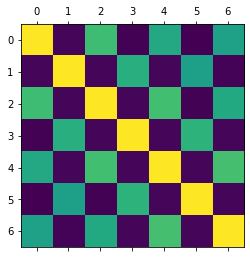

In [43]:
import matplotlib.pyplot as plt

plt.matshow(df.loc[:, df.columns.isin(['price', 'price_1', 'sold_1', 'sold_2', 'sold_3', 'price_2', 'sold'])].corr())
plt.show()

In [44]:
%%time

import statsmodels.api as sm

X = sm.add_constant(X) ## add offset

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   sold   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                 4.313e+04
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        00:29:37   Log-Likelihood:            -4.3505e+06
No. Observations:             1360779   AIC:                         8.701e+06
Df Residuals:                 1360743   BIC:                         8.701e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9131      0

In [0]:
## Cross validation for the last month
cvdf = get_cv_dataset(sales_original, 32)

X_cv = enc.transform(cvdf.loc[:, cvdf.columns != 'sold'])
X_cv = sm.add_constant(X_cv) ## add offset
Y_cv = cvdf.sold

predictions = model.predict(X_cv)

In [47]:
from statsmodels.tools.eval_measures import mse as mse
math.sqrt(mse(predictions, Y_cv)), model.mse_total

(17.156509971134057, 73.88989502150442)

In [48]:
### RANDOM CODE BITS                                        

### REALLY IMPORTANT - the most general version of 
##              groupby and aggregate concept                                  
In [3]: animals.groupby("item_id").agg(
   ...:     avg_price=pd.NamedAgg(column='height', aggfunc='min'),
   ...:     price=pd.NamedAgg(column='height', aggfunc='max'),
   ...:     average_weight=pd.NamedAgg(column='weight', aggfunc=np.mean),
   ...: )

   ## unused for now
## REDO THIS!
## don't delete, this unstack idea is top shit and will be needed for sure
def agg_months_as_columns(sales):
  df['month'] = df.time.dt.month
  df = pd.DataFrame(sales.groupby(['month', 'shop_id', 'item_id', \
                                   'item_price'])['item_cnt_day'].sum())
  df = df.unstack(level = 0)
  df = df.fillna(0)
  df.columns = df.columns.get_level_values(1)
  df.reset_index(drop = False, inplace = True)
  df.columns = ['shop_id', 'item_price','Jan', 'Feb',\
                'Mar',  'Apr', 'May',  'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
  return df


def get_sales_for_month(sales, month):
  df = pd.DataFrame(sales[sales.time.dt.month == month].groupby(['shop_id', 'item_id', 'item_price'])['item_cnt_day'].sum())
  df = df.fillna(0)
  df.columns = ['usual_sales_at_target_time']
  df.reset_index(drop = False, inplace = True)
  return df


### TODO: think about this forward selection stuff
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


NameError: ignored